In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import notebook_setup

from copy import deepcopy
import pickle
import warnings
import os
# warnings.filterwarnings("error", category=UserWarning)
os.makedirs(os.path.expanduser('~/Data/tensorboard/'), exist_ok=True)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import make_scorer, r2_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from pytorchbridge import TorchEstimator
from joblib import Parallel, delayed

from ppo import PPO, Memory, ActorCriticDiscrete, returns
from systems import LunarLanderEnv, random_lunarlander, plot_lunarlander
from utils import (cache_function, cache_to_episodic_rewards,
                   cache_to_episodes, copy_tensor, copy_mlp_regressor,
                   sanitize_filename, get_gradients)
from meta import (learn_env_model, meta_update, distance, prune_library,
                  plot_adaption, rank_policies, maml_initialize)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 0
NCPU = os.cpu_count() // 2

## System

In [3]:
env_name = 'LunarLander'
env = LunarLanderEnv(seed=SEED)
PhysicalEnv = LunarLanderEnv
DataEnv = None
nominal_config = dict(
    MAIN_ENGINE_POWER=13.,
    SIDE_ENGINE_POWER=0.6
)
env_fn = lambda seed=SEED: PhysicalEnv(seed=seed)

### Diagnosis

In [16]:
env = env_fn()
i, n=0, 20
for _ in trange(n, leave=False):
    env.reset()
    done=False
    while not done:
        _, _, done, _ = env.step(env.action_space.sample())
        i += 1
print('Average Episode length:', i / n)

Average Episode length: 91.3


### Degradation

In [ ]:
def degrade(env, time: float, factor: np.ndarray, **nominal):
    tanks = env.tanks
    if not isinstance(factor, (list, tuple, np.ndarray)):
        # If a single degradation factor given, assume it is
        # identical for all tanks.
        tfactor = np.ones(n_tanks) * tfactor
    
    for i in range(n_engines):
        tanks.engines[i] = nominal['engines'][i] + \
                           nominal['engines'][i] * time / efactor[i]


def random_degrade(env, random=np.random,
                   tfactors=(10, 20), efactors=(10, 20),
                   atmost_tanks=1, atmost_engines=1):
    n_tanks = len(tanks.heights)
    tanks = env.tanks
    tfactor = np.ones(n_tanks) * np.inf
    if atmost_tanks > 0:
        tanks_affected = random.randint(1, atmost_tanks + 1)
        idx_affected = random.choice(n_tanks, size=tanks_affected, replace=False)
        tfactor[idx_affected] = random.randint(*tfactors, size=tanks_affected)
        
    efactor = np.ones(n_engines) * np.inf
    if atmost_engines > 0:
        engines_affected = random.randint(1, atmost_engines + 1)
        idx_affected = random.choice(n_engines, size=engines_affected, replace=False)
        efactor[idx_affected] = random.randint(*efactors, size=engines_affected)
    
    degrade(env, min([t if t != np.inf else 0 for t in tfactor]), tfactor, efactor, **nominal_config)
    return tfactor, efactor

## Enhanced MAML

In [17]:
env = env_fn()
timesteps = 100000            # max timesteps in one episode

ppo_params = dict(
    state_dim = env.observation_space.shape[0],
    action_dim = 4,
    policy=ActorCriticDiscrete,
    epochs = 3,                  # update policy for K epochs
    lr = 0.001,                   # learning rate
    n_latent_var = 64,           # number of variables in hidden layer
    betas = (0.9, 0.999),
    gamma = 0.99,                # discount factor
    eps_clip = 0.2,              # clip parameter for PPO
    update_interval = 500,      # update policy every n timesteps
    seed = SEED
)
library_size = 4
random_library = False
random_fault = False
data_model = False
random = np.random.RandomState(SEED)

In [ ]:
# Nominal agent trained without fault
agent = PPO(env, **ppo_params)

In [20]:
r = agent.learn(timesteps, track_higher_gradients=False)

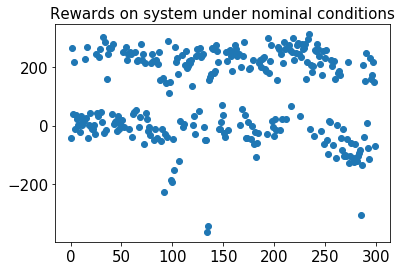

In [21]:
plt.scatter(np.arange(len(r)), r)
plt.title('Rewards on system under nominal conditions');
# plt.ylim(bottom=0, top=200)

In [ ]:
# Populate library of policies
library = []
library_rewards = []
library_envs = []
library_grads = []

if random_library:
    library_envs = [random_degrade(env_fn(), random) for _ in range(library_size)]
else:
    env_params = [
        # TODO
        ]
    for env_param in env_params:
        env_ = env_fn()
        env_.set_parameters(**env_param)
        library_envs.append(env_)

for env_ in tqdm(library_envs, leave=False):
    if data_model:
        est_ = copy_mlp_regressor(est)  # copy estimator hyperparameters etc.
        x, y = generate_training_data(env_, episodes=50)  # random actions!
        est_.fit(x, y)
        # Train agent on data-driven model
        env_ = DataEnv(env_, est_)
    agent_ = PPO(env_, **ppo_params)
    agent_.policy.load_state_dict(copy_tensor(agent.policy.state_dict()))
    rewards = agent_.learn(timesteps, track_higher_gradients=True)
    library.append(copy_tensor(agent_.policy.state_dict()))
    library_rewards.append(rewards)
    library_grads.append(get_gradients(agent_.meta_policy.parameters(), agent_.meta_policy.parameters(time=0)))

In [ ]:
# Plot library rewards
plt.figure(figsize=(6, 4))
for i, rewards in enumerate(library_rewards):
    plt.plot(rewards, label='Policy#{}'.format(i))
plt.title('Episodic rewards on process with faults')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.grid(True, 'both')
plt.tight_layout()

pth = f'./bin/{env_name}/'
os.makedirs(pth, exist_ok=True)
plt.savefig(pth+env_name+'_library_rewards.png')
with open(pth + env_name + '_library_rewards.pickle', 'wb') as f:
    pickle.dump(dict(library_rewards=library_rewards), f)

In [ ]:
# Faulty environment
env_ = env_fn()
if not random_fault:
    env_.set_parameters(
        MAIN_ENGINE_POWER=,
        SIDE_ENGINE_POWER=
    )
else:
    random_degrade(env_, random, **nominal_config)

### Experiment functions

In [ ]:
def adapt(agent, est, memory, library, interactive_env=True,
          n_inner=1, n_outer=1, alpha_inner=0.01, alpha_outer=0.1,
          mode='fomaml', library_grads=None, rank=-1, **ppo_params):
    env_ = agent.env
    params = meta_update(agent.policy.state_dict(), env_, library, memory,
                         n_inner, n_outer, alpha_inner, alpha_outer,
                         interactive_env, mode, library_grads, rank, **ppo_params)
    agent.policy.load_state_dict(params)
    return agent

def adapt_benchmark(agent, est, memory, library, interactive_env=True,
          n_inner=1, n_outer=1, alpha_inner=0.01, alpha_outer=0.1,
           mode=None, library_grads=None, rank=None, **ppo_params):
    env_ = agent.env
    agent.learn(ppo_params['update_interval'], ppo_params['update_interval'])
    return agent

In [ ]:
def trial(env_, est, starting_policy, library=[], interactive_env=False, post_steps=10000,
          n_inner=1, n_outer=1, alpha_inner=0.01, alpha_outer=0.1,
          mode='fomaml', library_grads=None, rank=-1, benchmark=True, seed=SEED):
    # local copy of ppo_params with seed overwritten with the trial seed
    ppo_params['seed'] = seed
    env_.seed(seed)
    # Make copies of env, and agent trained on nominal system,
    # and starting library of policies (if any)
    library_ = [copy_tensor(p) for p in library]
    agent_ = PPO(env_, **ppo_params)
    agent_.policy.load_state_dict(copy_tensor(starting_policy))
    # Fault occurs, buffer experience with environment
    memory_ = Memory()
    agent_.experience(memory_, 4*ppo_params['update_interval'], env_, agent_.policy)
    # Use meta-learning to adapt to fault
    agent_.env.reset()
    adapt(agent_, est, memory_, library_, interactive_env,
          n_inner, n_outer, alpha_inner, alpha_outer,
          mode, library_grads, rank, **ppo_params)
    if benchmark:
        library_maml, gradients_maml = \
            maml_initialize(starting_policy, env_fn, library_size,
                            n_inner, alpha_inner, **ppo_params)
        agent_benchmark_maml = PPO(env_, **ppo_params)
        agent_benchmark_maml.env.seed(seed)
        agent_benchmark_maml.env.reset()
        agent_benchmark_maml.policy.load_state_dict(copy_tensor(starting_policy))
        adapt(agent_benchmark_maml, est, memory_, library_maml, True,
              0, n_outer, alpha_inner, alpha_outer,
              mode, gradients_maml, rank=-1, **ppo_params)
        
        agent_benchmark_vanilla = PPO(env_, **ppo_params)
        agent_benchmark_vanilla.env.seed(seed)
        agent_benchmark_vanilla.env.reset()
        agent_benchmark_vanilla.policy.load_state_dict(copy_tensor(starting_policy))
        adapt_benchmark(agent_benchmark_vanilla, est, memory_, library_, data_model,
                        n_inner, n_outer, alpha_inner, alpha_outer,
                        **ppo_params)
        
    # Continue learning
    rewards = []
    agents = [agent_, agent_benchmark_maml, agent_benchmark_vanilla] if benchmark else [agent_]
    for a in tqdm(agents, desc='Post-fault training', leave=False):
        rewards.append(a.learn(post_steps))
    return rewards, agent_.policy.state_dict(), memory_



def ntrials(n=NCPU, verbose=10, *trial_args, **trial_kwargs):

    res = Parallel(n_jobs=min(n, NCPU), verbose=verbose)(
        delayed(trial)(*trial_args, seed=SEED+i, **trial_kwargs) for i in range(n)
    )
    # res = [
    #   [[[r..],[r..],[r..]], state_dict, memory]
    # ]
    n_rewards = len(res[0][0]) # our approach, maml, vanilla ppo
    means, stds = [], []
    for reward_idx in range(n_rewards):
        maxlen = max([len(r[0][reward_idx]) for r in res])
        rewards = np.empty((len(res), maxlen))
        rewards.fill(np.nan)
        for i, result in enumerate(res):
            rewards[i, :len(result[0][reward_idx])] = result[0][reward_idx]
        means.append(np.nanmean(rewards, axis=0))
        stds.append(np.nanstd(rewards, axis=0))
    return means, stds

### Grid-search

In [ ]:
grid = ParameterGrid(dict(
    alpha_inner = [1e-3, 1e-2, 1e-1],
    alpha_outer = [1e-3, 1e-2, 1e-1],
    n_inner = [0, 3],
    n_outer = [1, 3],
    data_model = [False],
    post_steps = [30000],
    library = [library],
    library_grads = [library_grads],
    rank = [-1, 1, 2],
    mode = ['maml', 'fomaml', 'reptile']
))

pth = f'./bin/{env_name}/hyperparameters/'
os.makedirs(pth, exist_ok=True)

env_ = env_fn()
env_.set_parameters(
    masscart=1.5,
    masspole=0.1,
    length=0.5,
    force_mag=-10,
)

hyp_r, hyp_std, hyp_rb, hyp_stdb = [], [], [], []
ngrid = 0
for trial_params in tqdm(grid, desc='Hyperparameters', leave=False):
    
    (r, r_b), (std, std_b) = ntrials(3, 10, env_, None, agent.policy.state_dict(), **trial_params)
    
    hyp_r.append(r)
    hyp_rb.append(r_b)
    hyp_std.append(std)
    hyp_stdb.append(std_b)
    ngrid += 1
    
    fname = pth + env_name + '_' + \
            sanitize_filename(str({k:v for k,v in trial_params.items() if not k.startswith('library')}))
    plt.figure(figsize=(10,8))
    plot_adaption((r, r_b), (std, std_b), ('e-MAML', 'Vanilla RL'));
    plt.savefig(fname + '.png')
    with open(fname+'.pickle', 'wb') as f:
        pickle.dump(dict(trial_params=trial_params, results=(r, r_b, std, std_b)), f)

In [ ]:
i=0
for trial_params, r, r_b, std, std_b in tqdm(zip(grid, hyp_r, hyp_std, hyp_rb, hyp_stdb), leave=False, total=len(grid)):
    
    fname = pth + env_name + '_' + \
            sanitize_filename(str({k:v for k,v in trial_params.items() if not k.startswith('library')}))
    plt.figure(figsize=(10,8))
    plot_adaption((r, r_b), (std, std_b), ('e-MAML', 'Vanilla RL'));
    plt.savefig(fname + '.png')
    plt.show()
    plt.close()
    i+=1
    if i==2: break

In [ ]:
ncol = 2
nrow = ngrid // ncol + (ngrid % ncol != 0)
plt.figure(figsize=(12, 3 * nrow))
for i, (grid_params, (r, r_b, std, std_b)) in enumerate(zip(grid, zip(hyp_r, hyp_rb, hyp_std, hyp_stdb))):
    plt.subplot(nrow, ncol, i + 1)
    plot_adaption((r, r_b), (std, std_b), ('e-MAML', 'Vanilla RL'));
    print([(k, len(v) if k=='library' else v) for k, v in grid_params.items() if k not in ['post_steps']])
    plt.title(i)
plt.tight_layout()

## Performance-weighed sampling

### Most favorable policy

In [ ]:
a = PPO(env_, **ppo_params)
a.policy.load_state_dict(agent.policy.state_dict())
m = Memory()
a.experience(m, ppo_params['update_interval'], env_, a.policy)

ret = torch.tensor(returns(m.rewards, m.is_terminals, a.gamma)).float().to(DEVICE)
ret = (ret - ret.mean()) / (ret.std() + 1e-5)
states = torch.tensor(m.states).float().to(DEVICE).detach()
actions = torch.tensor(m.actions).float().to(DEVICE).detach()

In [ ]:
args, vals = rank_policies(m, library, **ppo_params)

In [ ]:
np.asarray(vals)[args]

In [ ]:
args

In [ ]:
vals

### Plotting

In [ ]:
pth = f'./bin/{env_name}/rnd_vs_lib/'
os.makedirs(pth, exist_ok=True)

In [ ]:
trial_params = dict(
    alpha_inner = 1e-3,
    alpha_outer = 2e-3,
    n_inner = 3,
    n_outer = 3,
    interactive_env = False,
    post_steps = 30000,
    library = library,
    library_grads = library_grads,
    mode = 'maml',
    rank = 2,
    benchmark=True
)

In [ ]:
env_.reset()
(r, r_m, r_v), (std, std_m, std_v) = ntrials(1, 20, env_, None, agent.policy.state_dict(), **trial_params)

plt.figure(figsize=(6,4))
plot_adaption((r, r_m, r_v), (std, std_m, std_v), ('e-MAML', 'MAML', 'Vanilla RL'))

fname = pth + env_name + '_' + sanitize_filename(str({k:v for k,v in trial_params.items() if not k.startswith('library')}))

# plt.savefig(fname + '.png')
# with open(fname+'.pickle', 'wb') as f:
#     pickle.dump(dict(trial_params=trial_params, results=((r, r_m, r_v), (std, std_m, std_v))), f)

In [ ]:
trial_params['rank'] = -1
trial_params['benchmark'] = False

env_.reset()
(r2,), (std2,) = ntrials(1, 20, env_, None, agent.policy.state_dict(), **trial_params)

plt.figure(figsize=(6,4))
plot_adaption((r2, r, r_v), (std2, std, std_v), ('e-MAML (4)', 'e-MAML(2)', 'Vanilla RL'));

fname = pth + env_name + '_' + sanitize_filename(str({k:v for k,v in trial_params.items() if  not k.startswith('library')}))

# plt.savefig(fname + '.png')
# with open(fname+'.pickle', 'wb') as f:
#     pickle.dump(dict(trial_params=trial_params, results=(r, r_b, std, std_b)), f)

In [ ]:
plt.figure(figsize=(6,4))
plot_adaption((r2, r, r_m, r_v), (std2, std, std_m, std_v), ('e-MAML (rank=4)', 'e-MAML (rank=2)', 'MAML', 'Vanilla RL'))
plt.title('Performance-weighed sampling comparison')
plt.tight_layout()
fname = pth + env_name + '_' + 'rank_comparison'
plt.savefig(fname + '.png')

## Policy complement

### Learning complement

In [ ]:
comp = []
comp_rewards = []
comp_envs = []

e_params = [
        dict(resistances=[100, 100, 100, 70,  80,   90], pumps=[0.1, 0.1, 0.1, 0.,  0.1, 0.1], engines=[0.05, 0.1]),
        dict(resistances=[100, 100, 100, 70,  80,   90], pumps=[0. , 0.1, 0.1, 0.,  0.1, 0.1], engines=[0.05, 0.1]),
        dict(resistances=[100, 100, 100, 150, 200, 100], pumps=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1], engines=[0.1, 0.05]),
        dict(resistances=[100, 100, 100, 150, 200, 100], pumps=[0.1, 0.1, 0.1, 0.1, 0. , 0. ], engines=[0.1, 0.05]),
        dict(resistances=[90,  100, 100, 70,   80,  90], pumps=[0.1, 0.1, 0.,  0.1, 0.1, 0.1], engines=[0.05, 0.1]),
        dict(resistances=[90,  100, 100, 70,   80,  90], pumps=[0. , 0.1, 0.,  0.1, 0.1, 0. ], engines=[0.05, 0.1]),
        dict(resistances=[100,  75, 100, 100,  75, 100], pumps=[0.1, 0. , 0.1, 0.1, 0.1, 0.1], engines=[0.05, 0.1]),
]
for e_param in e_params:
    e = env_fn()
    e.set_parameters(**e_param)
    comp_envs.append(e)

# factors = [random_degrade(**nominal_config) for _ in range(3)]

for e in tqdm(comp_envs, leave=False):
    agent_ = PPO(e, **ppo_params)
    agent_.policy.load_state_dict(copy_tensor(agent.policy.state_dict()))
    rewards = agent_.learn(50000, track_higher_gradients=False)
    comp.append(copy_tensor(agent_.policy.state_dict()))
    comp_rewards.append(rewards)

In [ ]:
a = PPO(env, **ppo_params)
a.policy.load_state_dict(agent.policy.state_dict())
m = Memory()
a.experience(m, ppo_params['update_interval'], env, a.policy)

In [ ]:
comp_, divmat, idx = prune_library(comp, library_size, m, **ppo_params)

In [ ]:
idx[1][0]

In [ ]:
divmat.sum(axis=1)

### Plotting

In [ ]:
pth = f'./bin/{env_name}/complement/'
os.makedirs(pth, exist_ok=True)

In [ ]:
trial_params = dict(
    alpha_inner = 1e-3,
    alpha_outer = 2e-3,
    n_inner = 3,
    n_outer = 3,
    interactive_env = False,
    post_steps = 30000,
    library = comp_,
    library_grads = None,
    mode = 'fomaml',
    rank = -1,
    benchmark=True
)

In [ ]:
env_.reset()
(r, r_m, r_v), (std, std_m, std_v) = ntrials(1, 20, env_, None, agent.policy.state_dict(), **trial_params)

plt.figure(figsize=(6,4))
plot_adaption((r, r_m, r_v), (std, std_m, std_v), ('e-MAML(most divergent)', 'MAML', 'Vanilla RL'))

fname = pth + env_name + '_' + sanitize_filename(str({k:v for k,v in trial_params.items() if not k.startswith('library')}))

# plt.savefig(fname + '.png')
# with open(fname+'.pickle', 'wb') as f:
#     pickle.dump(dict(trial_params=trial_params, results=((r, r_m, r_v), (std, std_m, std_v))), f)

In [ ]:
trial_params['library'] = [comp[i] for i in range(len(comp)) if i not in idx[0][1]]
trial_params['rank'] = -1
trial_params['benchmark'] = False

env_.reset()
(r2,), (std2,) = ntrials(1, 20, env_, None, agent.policy.state_dict(), **trial_params)

plt.figure(figsize=(6,4))
plot_adaption((r, r2, r_v), (std, std2, std_v), ('e-MAML (most divergent)', 'e-MAML(least divergent)', 'Vanilla RL'));

fname = pth + env_name + '_' + sanitize_filename(str({k:v for k,v in trial_params.items() if  not k.startswith('library')}))

# plt.savefig(fname + '.png')
# with open(fname+'.pickle', 'wb') as f:
#     pickle.dump(dict(trial_params=trial_params, results=(r, r_b, std, std_b)), f)

In [ ]:
plt.figure(figsize=(6,4))
plot_adaption((r, r2, r_m, r_v), (std, std2, std_m, std_v), ('e-MAML (4 most divergent)', 'e-MAML (3 least divergent)', 'MAML', 'Vanilla RL'))
plt.title('Complement divergence comparison')
plt.tight_layout()
fname = pth + env_name + '_' + 'divergence_comparison'
plt.savefig(fname + '.png')

## $\Delta \theta$ Approximations

In [ ]:
pth = f'./bin/{env_name}/deltatheta/'
os.makedirs(pth, exist_ok=True)

In [ ]:
trial_params = dict(
    alpha_inner = 1e-3,
    alpha_outer = 2e-3,
    n_inner = 3,
    n_outer = 3,
    interactive_env = False,
    post_steps = 30000,
    library = library,
    library_grads = library_grads,
    mode = 'maml',
    rank = 2,
    benchmark=True
)

In [ ]:
env_.reset()
(r, r_m, r_v), (std, std_m, std_v) = ntrials(1, 20, env_, None, agent.policy.state_dict(), **trial_params)

plt.figure(figsize=(6,4))
plot_adaption((r, r_v), (std, std_v), ('MAML', 'Vanilla RL'))

fname = pth + env_name + '_' + sanitize_filename(str({k:v for k,v in trial_params.items() if not k.startswith('library')}))

# plt.savefig(fname + '.png')
# with open(fname+'.pickle', 'wb') as f:
#     pickle.dump(dict(trial_params=trial_params, results=((r, r_m, r_v), (std, std_m, std_v))), f)

In [ ]:
trial_params['mode'] = 'fomaml'
trial_params['benchmark'] = False

env_.reset()
(r2,), (std2,) = ntrials(1, 20, env_, None, agent.policy.state_dict(), **trial_params)

plt.figure(figsize=(6,4))
plot_adaption((r, r2, r_v), (std, std2, std_v), ('MAML', 'FOMAML', 'Vanilla RL'));

fname = pth + env_name + '_' + sanitize_filename(str({k:v for k,v in trial_params.items() if  not k.startswith('library')}))

# plt.savefig(fname + '.png')
# with open(fname+'.pickle', 'wb') as f:
#     pickle.dump(dict(trial_params=trial_params, results=(r, r_b, std, std_b)), f)

In [ ]:
trial_params['mode'] = 'reptile'
trial_params['benchmark'] = False

env_.reset()
(r3,), (std3,) = ntrials(1, 20, env_, None, agent.policy.state_dict(), **trial_params)

plt.figure(figsize=(6,4))
plot_adaption((r, r2, r_v), (std, std2, std_v), ('e-MAML (most divergent)', 'e-MAML(least divergent)', 'Vanilla RL'));

fname = pth + env_name + '_' + sanitize_filename(str({k:v for k,v in trial_params.items() if  not k.startswith('library')}))

# plt.savefig(fname + '.png')
# with open(fname+'.pickle', 'wb') as f:
#     pickle.dump(dict(trial_params=trial_params, results=(r, r_b, std, std_b)), f)

In [ ]:
plt.figure(figsize=(6,4))
plot_adaption((r, r2, r3), (std, std2, std3), ('MAML', 'FOMAML', 'REPTILE'))
plt.title('Update step approximation comparison')
plt.tight_layout()
fname = pth + env_name + '_' + 'deltatheta_comparison_' + ('ranked' if trial_params['rank'] > 0 else 'unranked')
plt.savefig(fname + '.png')